In [1]:
import modelling_lib_rodrixx as mod
import preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

import xgboost as xgb

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1980_to_2021.pkl'))

In [4]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,1,Kareem Abdul-Jabbar,C,32,LAL,82,-10,38.3,10.2,16.9,...,7,2,1,0.732,82,2,1.000,147,0.665,221
1,2,Tom Abernethy,PF,25,GSW,67,-10,18.2,2.3,4.7,...,32,54,41,0.293,82,44,0.817,0,0.000,221
2,3,Alvan Adams,C,25,PHO,75,-10,28.9,6.2,11.7,...,11,12,12,0.671,82,6,0.915,0,0.000,221
3,4,Tiny Archibald,PG,31,BOS,80,80,35.8,4.8,9.9,...,33,31,20,0.744,82,1,0.976,2,0.009,221
4,5,Dennis Awtrey,C,31,CHI,26,-10,21.5,1.0,2.3,...,21,56,42,0.366,82,38,0.317,0,0.000,221


In [5]:
cols_to_drop = ['Rk', 'GT', 'Votes', 'MaxVotes', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos']
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
cols_to_ohe = ['Pos', 'Tm']

In [6]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [7]:
df = pipe_clean.fit_transform(df)

In [8]:
df.head()

,,Age,G,GS,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,...,WS_rank,WS/48_rank,OBPM_rank,DBPM_rank,BPM_rank,VORP_rank,%W,%W_rank,%G,Share
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1980,32,82,-10,38.3,10.2,16.9,0.604,0.0,0.0,0.000,...,1,1,5,7,2,1,0.732,2,1.000,0.665
2,1980,25,67,-10,18.2,2.3,4.7,0.481,0.0,0.0,0.000,...,71,83,50,32,54,41,0.293,44,0.817,0.000
3,1980,25,75,-10,28.9,6.2,11.7,0.531,0.0,0.0,0.000,...,27,21,23,11,12,12,0.671,6,0.915,0.000
4,1980,31,80,80,35.8,4.8,9.9,0.482,0.1,0.2,0.222,...,14,25,26,33,31,20,0.744,1,0.976,0.009
5,1980,31,26,-10,21.5,1.0,2.3,0.450,0.0,0.0,0.000,...,85,109,63,21,56,42,0.366,38,0.317,0.000


In [9]:
len(df[df.index.get_level_values(1) > 2015]) / len(df)

0.17507805847289243

In [10]:
val_df = df[df.index.get_level_values(1) > 2015]
dev_df = df[df.index.get_level_values(1) <= 2015]

In [11]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [12]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [13]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [14]:
mlflow.set_experiment('NBA MVP prediction Ensemble')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/6', experiment_id='6', lifecycle_stage='active', name='NBA MVP prediction Ensemble', tags={}>

In [15]:
params_1 = {
    'colsamples_bytree': .7,
    'learning_rate': .2,
    'max_depth': 3,
    'n_estimators': 150,
    'subsample': .7,
    'random_state': 23
}

params_2 = {
    'max_depth': 8,
    'max_features': .5,
    'min_samples_split': 10,
    'n_estimators': 220,
    'random_state': 23
}

In [23]:
with mlflow.start_run():
    estimator_1 = xgb.XGBRegressor(**params_1)
    estimator_2 = RandomForestRegressor(**params_2)

    model = VotingRegressor([('xgb', estimator_1), ('rf', estimator_2)], weights = [.7, .3], verbose = True)

    cv_scores = cross_validate(model, X_train, y_train, scoring = ('neg_root_mean_squared_error', 'r2'), cv = 10)

    model.fit(X_train, y_train)

    params = model.get_params()

    predicted_targets = mod.predict_model(model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_ens(params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_))

[23:30:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "colsamples_bytree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[Voting] ...................... (1 of 2) Processing xgb, total=  10.8s
[Voting] ....................... (2 of 2) Processing rf, total= 1.0min
[23:32:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "colsamples_bytree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[Voting] ...................... (1 of 2) Process

2022/08/04 23:45:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\marcr\AppData\Local\Temp\tmpsutfwcsj\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


In [24]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.011514,0.013340,0.027209
R2,0.994173,0.980648,0.768797


In [25]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

In [26]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
105,2016,Stephen Curry,1.000,0.963493
263,2016,Kawhi Leonard,0.484,0.397212
222,2016,LeBron James,0.482,0.278529
452,2016,Russell Westbrook,0.371,0.235993
126,2016,Kevin Durant,0.112,0.409038
348,2016,Chris Paul,0.082,0.041594
167,2016,Draymond Green,0.038,0.068755
266,2016,Damian Lillard,0.020,0.028397
178,2016,James Harden,0.007,0.111131


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.421236
173,2017,James Harden,0.746,0.629152
261,2017,Kawhi Leonard,0.495,0.503495
221,2017,LeBron James,0.330,0.246015
425,2017,Isaiah Thomas,0.080,0.092589
98,2017,Stephen Curry,0.051,0.205423
16,2017,Giannis Antetokounmpo,0.007,0.076126
453,2017,John Wall,0.007,0.084229
100,2017,Anthony Davis,0.002,0.136713


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.824207
249,2018,LeBron James,0.731,0.419924
122,2018,Anthony Davis,0.441,0.174169
298,2018,Damian Lillard,0.205,0.195711
508,2018,Russell Westbrook,0.075,0.218962
16,2018,Giannis Antetokounmpo,0.074,0.092970
143,2018,Kevin Durant,0.065,0.181281
130,2018,DeMar DeRozan,0.032,0.023066
7,2018,LaMarcus Aldridge,0.006,0.027950


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.584369
207,2019,James Harden,0.768,0.639911
184,2019,Paul George,0.352,0.100982
270,2019,Nikola Jokić,0.210,0.121189
124,2019,Stephen Curry,0.173,0.098242
305,2019,Damian Lillard,0.068,0.163243
155,2019,Joel Embiid,0.049,0.071283
150,2019,Kevin Durant,0.025,0.162052
301,2019,Kawhi Leonard,0.013,0.163683


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.703468
251,2020,LeBron James,0.746,0.410958
199,2020,James Harden,0.363,0.417641
134,2020,Luka Dončić,0.198,0.205786
294,2020,Kawhi Leonard,0.166,0.127480
123,2020,Anthony Davis,0.081,0.201087
396,2020,Chris Paul,0.026,0.004432
297,2020,Damian Lillard,0.023,0.198264
262,2020,Nikola Jokić,0.018,0.046096


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.573485
146,2021,Joel Embiid,0.580,0.133561
116,2021,Stephen Curry,0.449,0.117763
12,2021,Giannis Antetokounmpo,0.345,0.262817
396,2021,Chris Paul,0.138,0.008205
130,2021,Luka Dončić,0.042,0.199906
297,2021,Damian Lillard,0.038,0.286077
421,2021,Julius Randle,0.020,0.028129
439,2021,Derrick Rose,0.010,0.000102


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
1,2016,Quincy Acy,0.0,0.000145
4,2016,Arron Afflalo,0.0,0.000439
5,2016,Alexis Ajinça,0.0,0.000122
6,2016,Cole Aldrich,0.0,0.001675
7,2016,LaMarcus Aldridge,0.0,0.025762
...,...,...,...,...
533,2021,James Wiseman,0.0,0.000100
534,2021,Christian Wood,0.0,0.000690
535,2021,Robert Woodard II,0.0,0.000415


In [27]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
378,2016,Rajon Rondo,0.0,0.199719
66,2017,Jimmy Butler,0.0,0.102501
156,2017,Rudy Gobert,0.0,0.146046
525,2020,Trae Young,0.0,0.123219
528,2021,Zion Williamson,0.0,0.103097


In [28]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

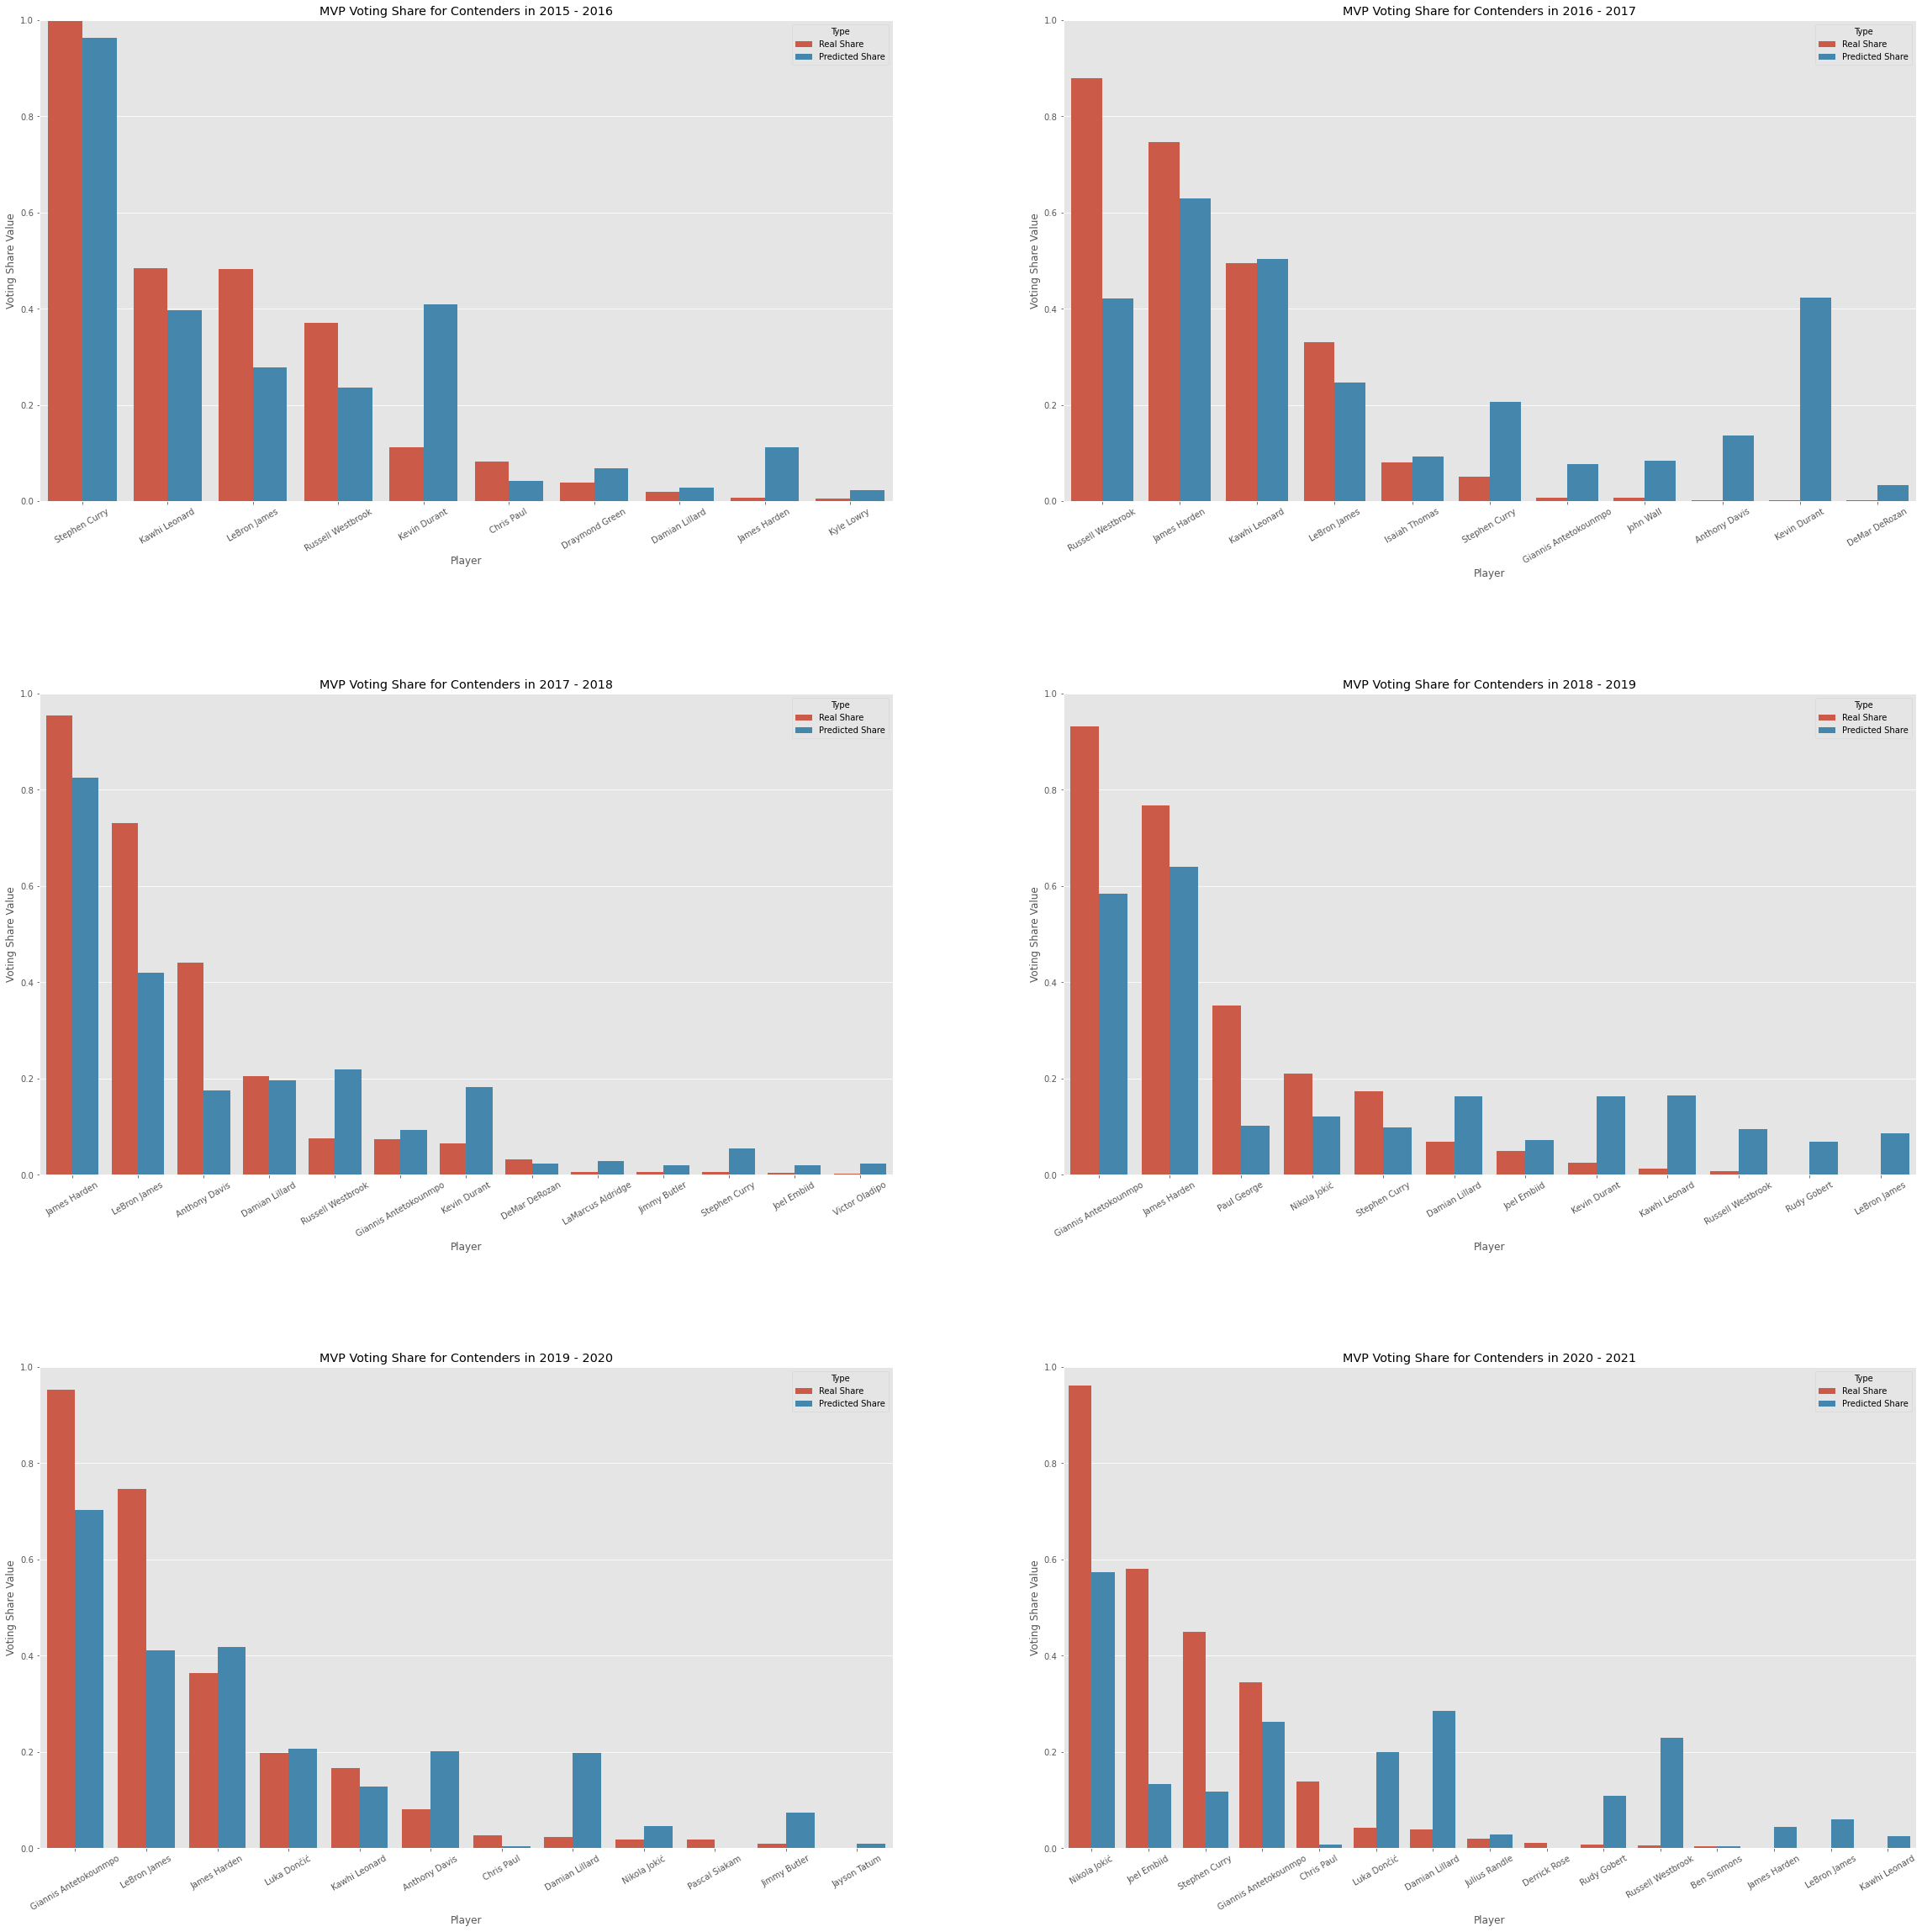

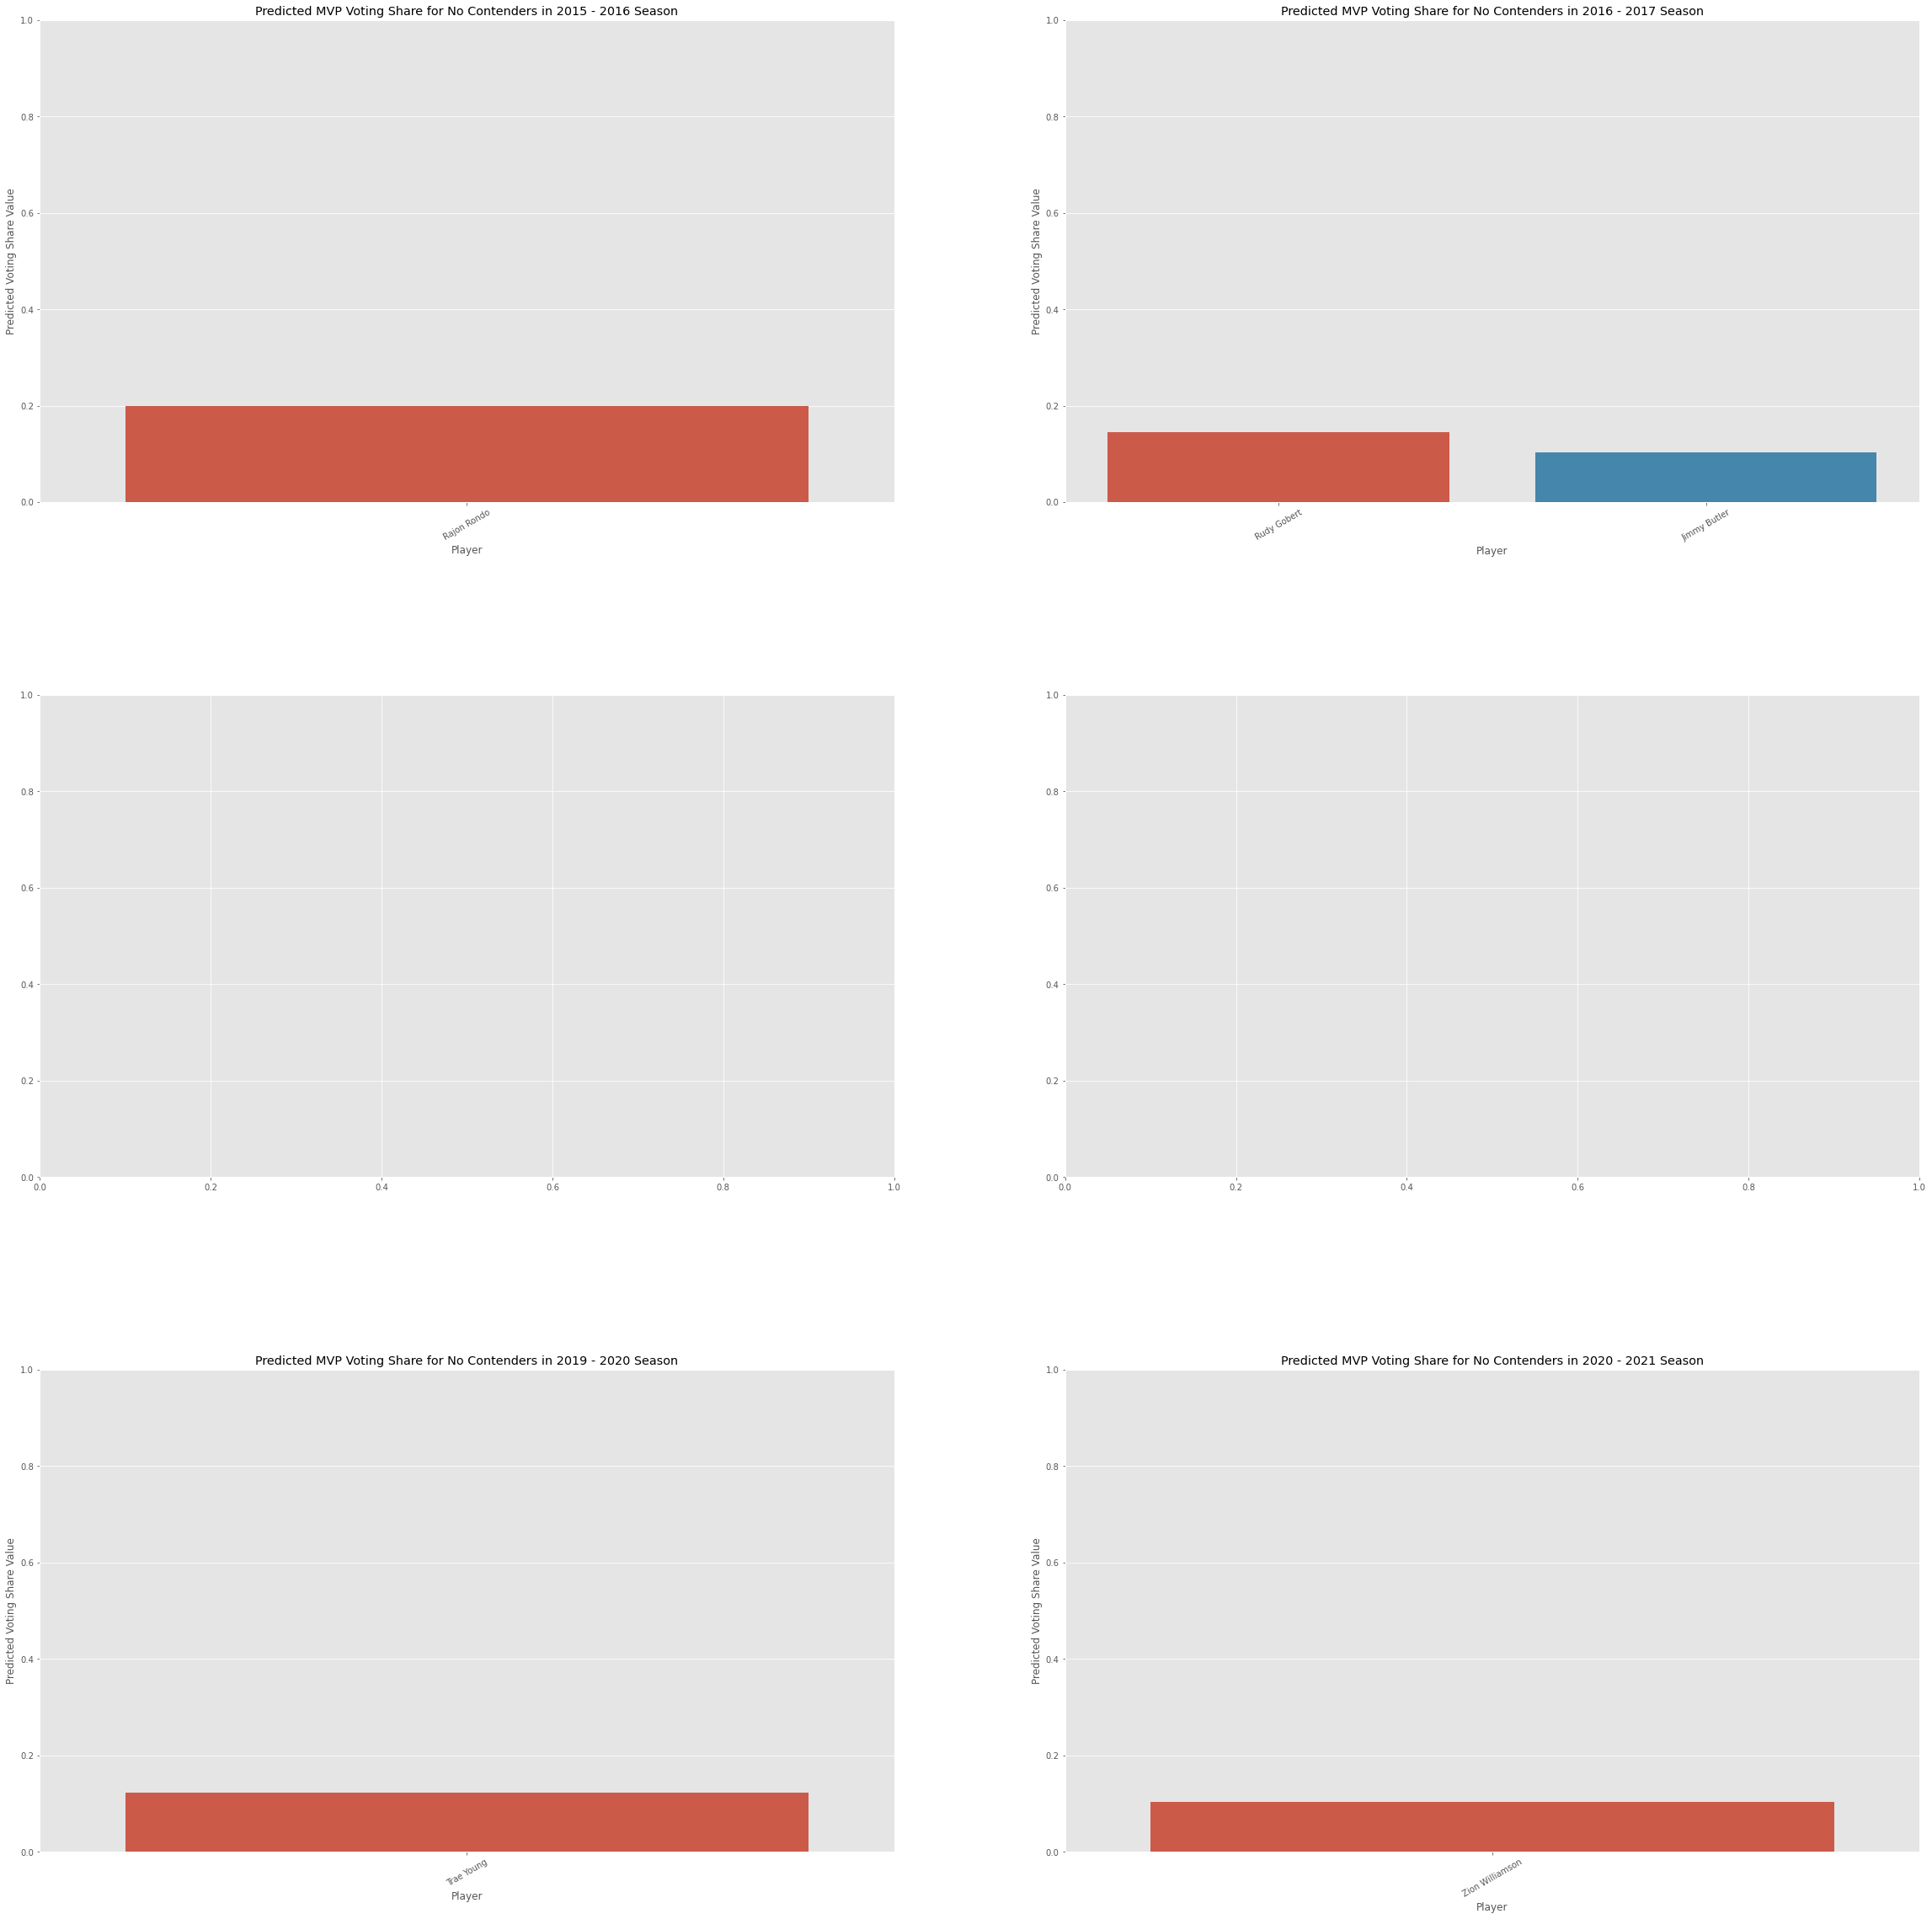

In [29]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)